## ROI Extraction

In [1]:
import cv2
import math
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function, Variable
from torchvision import transforms, models
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets
import itertools
import matplotlib.pyplot as plt
import time
from PIL import Image, ImageDraw, ImageFont
import copy
torch.set_default_dtype(torch.float64)

from networks.ROILAnet import ROILAnet
from networks.TPSGridGen import TPSGridGen
import mediapipe as mp

In [2]:
# Initialize MediaPipe Hands.
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)

# Initialize MediaPipe Drawing.
mp_drawing = mp.solutions.drawing_utils

I0000 00:00:1707737760.741215    9686 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1707737760.798645    9731 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.154.05), renderer: NVIDIA GeForce GTX 1660 SUPER/PCIe/SSE2


In [3]:
def classify_hand(hand_landmarks, image_width, image_height):
    """
    Classify the hand as left or right based on the x-coordinates of the thumb and index finger base.

    Parameters:
    - hand_landmarks: The hand landmarks object from MediaPipe.
    - image_width, image_height: Dimensions of the image to convert normalized coordinates into pixel coordinates.

    Returns:
    - A string indicating whether the hand is 'Left' or 'Right'.
    """
    # Convert normalized coordinates to pixel coordinates for thumb tip and index base
    thumb_tip = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP]
    index_base = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_MCP]

    thumb_tip_x_px = thumb_tip.x * image_width
    index_base_x_px = index_base.x * image_width

    # Determine orientation
    if thumb_tip_x_px > index_base_x_px:
        return 'Right'  # For the viewer, this appears as a left hand, but it's actually the right hand from the person's perspective
    else:
        return 'Left'  # Similarly, this appears as a right hand but it's the left hand from the person's perspective


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [4]:
def keypoints_detection_and_filter_index_image_rotation(img_path):

    # Load an image.
    image = cv2.imread(img_path)

    # Convert the image color from BGR to RGB.
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Process the image and detect hands.
    results = hands.process(image_rgb)
    img_show=image.copy()

    # Draw hand landmarks.
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(img_show, hand_landmarks, mp_hands.HAND_CONNECTIONS)


    if results.multi_hand_landmarks:
        # Assuming you have the image's dimensions
        image_width, image_height = image.shape[1], image.shape[0]

        for hand_landmarks in results.multi_hand_landmarks:
            # Extract MCP joints for Index, Middle, Ring, and Pinky fingers, as well as the Wrist and Thumb MCP
            index_mcp = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_MCP]
            middle_mcp = hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_MCP]
            ring_mcp = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_MCP]
            pinky_mcp = hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_MCP]
            wrist = hand_landmarks.landmark[mp_hands.HandLandmark.WRIST]
            thumb_mcp = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_CMC]  # Note: Using THUMB_CMC for Thumb MCP

            # Convert normalized coordinates to pixel coordinates
            index_mcp_px = (int(index_mcp.x * image_width), int(index_mcp.y * image_height))
            middle_mcp_px = (int(middle_mcp.x * image_width), int(middle_mcp.y * image_height))
            ring_mcp_px = (int(ring_mcp.x * image_width), int(ring_mcp.y * image_height))
            pinky_mcp_px = (int(pinky_mcp.x * image_width), int(pinky_mcp.y * image_height))
            wrist_px = (int(wrist.x * image_width), int(wrist.y * image_height))
            thumb_mcp_px = (int(thumb_mcp.x * image_width), int(thumb_mcp.y * image_height))

            hand_orientation = classify_hand(hand_landmarks, image_width, image_height)
            print(f"Hand is classified as: {hand_orientation}")
        points = np.array([
            index_mcp_px,
            middle_mcp_px,
            ring_mcp_px,
            pinky_mcp_px,
            (wrist_px[0],pinky_mcp_px[1]),
            wrist_px,
            thumb_mcp_px
        ], dtype=np.int32)
    else:
       return "No Hand Detected", "No Matrix", "No Points"
    # Example coordinates for Index Finger MCP and Pinky MCP in pixels
    x_index, y_index = index_mcp.x, index_mcp.y  # Replace with actual pixel coordinates of Index Finger MCP
    x_pinky, y_pinky = pinky_mcp.x, pinky_mcp.y  # Replace with actual pixel coordinates of Pinky MCP

    distance = math.sqrt( (y_index - y_pinky)**2 + (x_index - x_pinky)**2 )
    unit_vector = (((x_pinky - x_index)/distance), ((y_pinky - y_index)/distance))

    # print("Unit Vector: ", unit_vector)

    angle_with_horizontal = math.atan2(unit_vector[1], unit_vector[0])
    angle_with_horizontal = angle_with_horizontal * (180 / math.pi)

    # print("Angle with horizontal: ", angle_with_horizontal)
    rotation_angle = 0

    if hand_orientation == "Right":
      if -180 <= angle_with_horizontal <= -90:
        rotation_angle = angle_with_horizontal + 180
      elif 0 <= angle_with_horizontal <= 180:
        rotation_angle = angle_with_horizontal - 180
      else:
        rotation_angle = 180 - angle_with_horizontal

    else:
      if -180 <= angle_with_horizontal <= -90:
        rotation_angle = angle_with_horizontal + 180
      elif -90 <= angle_with_horizontal <= 180:
        rotation_angle = angle_with_horizontal

    # print("Rotation Angle: ", rotation_angle)
    # Image dimensions
    image_height, image_width = image.shape[:2]

    # Center of rotation - we'll rotate the image around its center
    center = (image_width // 2, image_height // 2)

    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)

    # Perform the rotation
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image_width, image_height))


    return rotated_image, rotation_matrix, points



In [5]:
def extract_roi(img_path):

    rotated_image, rotation_matrix ,points = keypoints_detection_and_filter_index_image_rotation(img_path)
    if type(points) == str:
        return "No Hand Detected"
    ones = np.ones(shape=(len(points), 1))
    points_ones = np.hstack([points, ones])

    # Apply the rotation matrix to the points
    new_points = cv2.transform(np.array([points_ones]), rotation_matrix)

    # The result is a 3D array, convert it back to 2D
    new_points = new_points.squeeze()

    new_points = np.round(new_points).astype(np.int32)

    x, y, w, h = cv2.boundingRect(new_points)

    # Crop the image using the bounding rectangle
    cropped_image = rotated_image[y:y+h, x:x+w]

    return cropped_image

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def loadCNNModel(weightPath):
    """
    @weightPath: path to the ROILAnet() weights
    loads localization network with pretrained weights
    """
    model = models.resnet18(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 600)
    model.load_state_dict(torch.load(weightPath, map_location=torch.device(device)))
    model.fc = nn.Identity()
    model.to(device)
    return model

In [7]:
recognitionNetwork = loadCNNModel('weights/resnet18_tongji_unfreezed_extractor.pt')
recognitionNetwork.eval()

/home/athenaai/anaconda3/envs/palm_recognition/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/athenaai/anaconda3/envs/palm_recognition/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Prediction Area

In [13]:
test_image_path1 = 'test_images/00001.tiff'
test_image_path2 = 'test_images/00002.tiff'

In [14]:
def extract_features(path: str):
    """
    Single Image Prediction
    @path: path to hand image (Tongji)
    """
    CNNtransformer = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # inputPIL = Image.open(path).convert('RGB')

    roi = extract_roi(path)
    # Convert NumPy array to PIL Image
    img_pil = Image.fromarray(roi)
    img = CNNtransformer(img_pil)
    plt.figure(figsize=(5,5))
    # plt.subplot(4,1,4)
    plt.imshow((img.cpu()[0]),cmap='gray')
    plt.title('Preprocessed for CNN classification')
    img = img.view(1,img.size(0),img.size(1),img.size(2))
    img = img.to(device)

    with torch.no_grad():
        resp = recognitionNetwork.forward(img)
        
    plt.show()

    return resp

Hand is classified as: Left


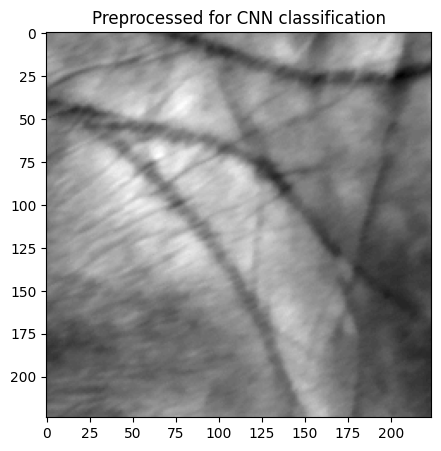

Hand is classified as: Left


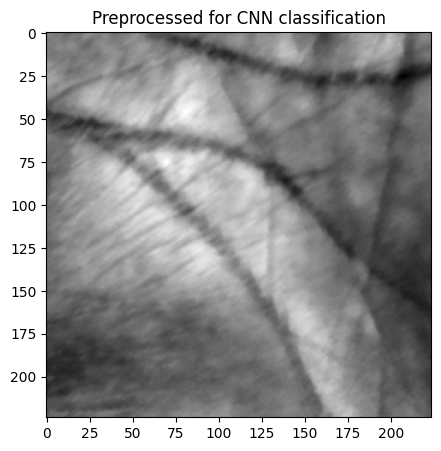

In [18]:
inference1 = extract_features(test_image_path1)
inference2 = extract_features(test_image_path2)
inference1 = torch.flatten(inference1)
inference2 = torch.flatten(inference2)

In [19]:
import numpy as np
import torch.nn.functional as F
def calculate_cosine_similarity(output1, output2):

    cosine_sim = F.cosine_similarity(output1, output2, dim=0)

    return cosine_sim.item()

calculate_cosine_similarity(inference1,inference2)

0.9715110860366722